
## Home Decor Demand Forecasting with Explainable AI
This project helps an e-commerce business understand and explain what drives customer purchases in the home decor category — so teams across marketing, inventory, and strategy can act on it.

We already have two trained forecasting models (Random Forest and K-Nearest Neighbors) that predict next month’s home decor sales. Now, we’re applying Explainable AI (XAI) to open the black box and answer:

“Why does the model think a customer will (or won’t) purchase home decor next month?”

We use SHAP (Shapley Additive Explanations) — a game-theory-based tool — to break down each prediction and highlight the most important features.

---
## Project Goals

- Find out what features drive future home decor purchases

- Compare explanations from Random Forest and KNN

- Translate model insights into business decisions

- Support marketing, inventory, and strategy teams with action-ready insights

---
## Why This Matters to the Business

- Marketing can better target customers with relevant ads and offers

- Inventory can plan stock more efficiently based on purchase trends

- Strategy can create bundles and pricing strategies around related categories

If customers who buy children’s accessories also tend to buy home decor, we can run cross-sell promotions or create category bundles.

---
## Data

Each row in `X_train` represents a snapshot of a customer's features for a specific month, and `y_train` is the customer's sales for the next month for the `'home_decor'` product category. The data is a modified version of the original data that is publicly available on Kaggle.

[//]: # (https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business/data)

### X_train/X_test.csv

| Column | Description |
|--------|------------|
| `logsales` | Logarithm of (customer sales+1) (+1 to handle 0 sales) |
| `lag1` | The log of sales from 1 month ago |
| `lag2`| The log of sales from 2 months ago|
| `sma_2m` | Average log sales over the last 2 months (simple moving average)|
| `sma_4m` | Average log sales over the last 4 months (simple moving average)|
| `sma_6m` | Average log sales over the last 5 months (simple moving average)|
| `months_since_first` | Months since first purchase |
|<ul><li>`children_s_accessories`</li><li>`colourful_essentials`</li><li>`home_decor`</li><li>`home_storage`</li><li>`quirky_stationery`</li><li>`soft_furnishings`</li><li>`toys_games`</li>...</ul> | Category-specific logarithm of (customer sales+1) | 
| <ul><li>`sma_2m__birthday_gifts`</li><li>`sma_4m__birthday_gifts`</li><li>`sma_3m__birthday_gifts` | 2, 4, 6-month average log sales per category (simple moving average)|

### y_train/y_test.csv

- `'nextmonth__home_decor'`: Logarithm of (customer sales+1) for the `home_decor` product category in the next month for prediction

---
## Model

This forecast model has been trained on the `X_train`, `y_train` provided.

Both models are trained and ready to go:

- model.pkl: a trained Random Forest Regressor

- knn_model.pkl: a trained K-Nearest Neighbors Regressor

### model.pkl

- Fitted `sklearn.ensemble.RandomForestRegressor` on `X_train`, `y_train`

### knn_model.pkl

- Fitted `sklearn.neighbors.KNeighborsRegressor` on `X_train`, `y_train`

We’ll use SHAP to explain both and compare their top predictive features.

___
### Compatibility Note (Python 3.10 Required)

Due to how frequently the libraries required for this project are updated, you'll need to update your environment to Python 3.10.


## At the end of this project, we will Learn in the Notebook

- How SHAP explains Random Forest using TreeExplainer

- How SHAP explains KNN using KernelExplainer

- Which 5 features matter most to each model

- Whether the explanations agree across both models (measured with cosine similarity)

- How to interpret the SHAP summary plot to guide marketing or supply chain

## Home Decor Sales Forecasting: Explainable AI (XAI) Model Interpretation

#### Purpose: Help marketing, supply chain, and exec teams understand what drives next month's home decor sales using explainable machine learning.

#### This script uses SHAP (SHapley Additive exPlanations) to explain how two models — Random Forest and K-Nearest Neighbors (KNN) — make predictions.

In [1]:
# Re-run this cell
# Import required libraries
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import joblib
import sys
assert (
    sys.version_info.major == 3 and sys.version_info.minor == 10
), "Please ensure that you are on Python 3.10."

# Load a sample of the data and the models
X_train = pd.read_csv("data/X_train.csv").sample(500, random_state=42)
X_test = pd.read_csv("data/X_test.csv").sample(500, random_state=42)
y_train = pd.read_csv("data/y_train.csv")["nextmonth__home_decor"].sample(500, random_state=42)
y_test = pd.read_csv("data/y_test.csv")["nextmonth__home_decor"].sample(500, random_state=42)
model = joblib.load("data/model.pkl")
knn_model = joblib.load("data/knn_model.pkl")

  0%|          | 0/10 [00:00<?, ?it/s]


XAI Method Used: SHAP
Top 5 Features from Random Forest:
                          feature  importance
2                           lag2    0.117177
4                         sma_4m    0.098794
1                           lag1    0.095220
3                         sma_2m    0.059562
44  sma_2m__colourful_essentials    0.058533
Top 5 Features from KNN:
   feature  importance
4  sma_4m    0.193735
2    lag2    0.188900
1    lag1    0.095701
3  sma_2m    0.046959
5  sma_6m    0.037013
Feature Importance Consistency Score: 0.96
Are Interpretations Reliable? yes


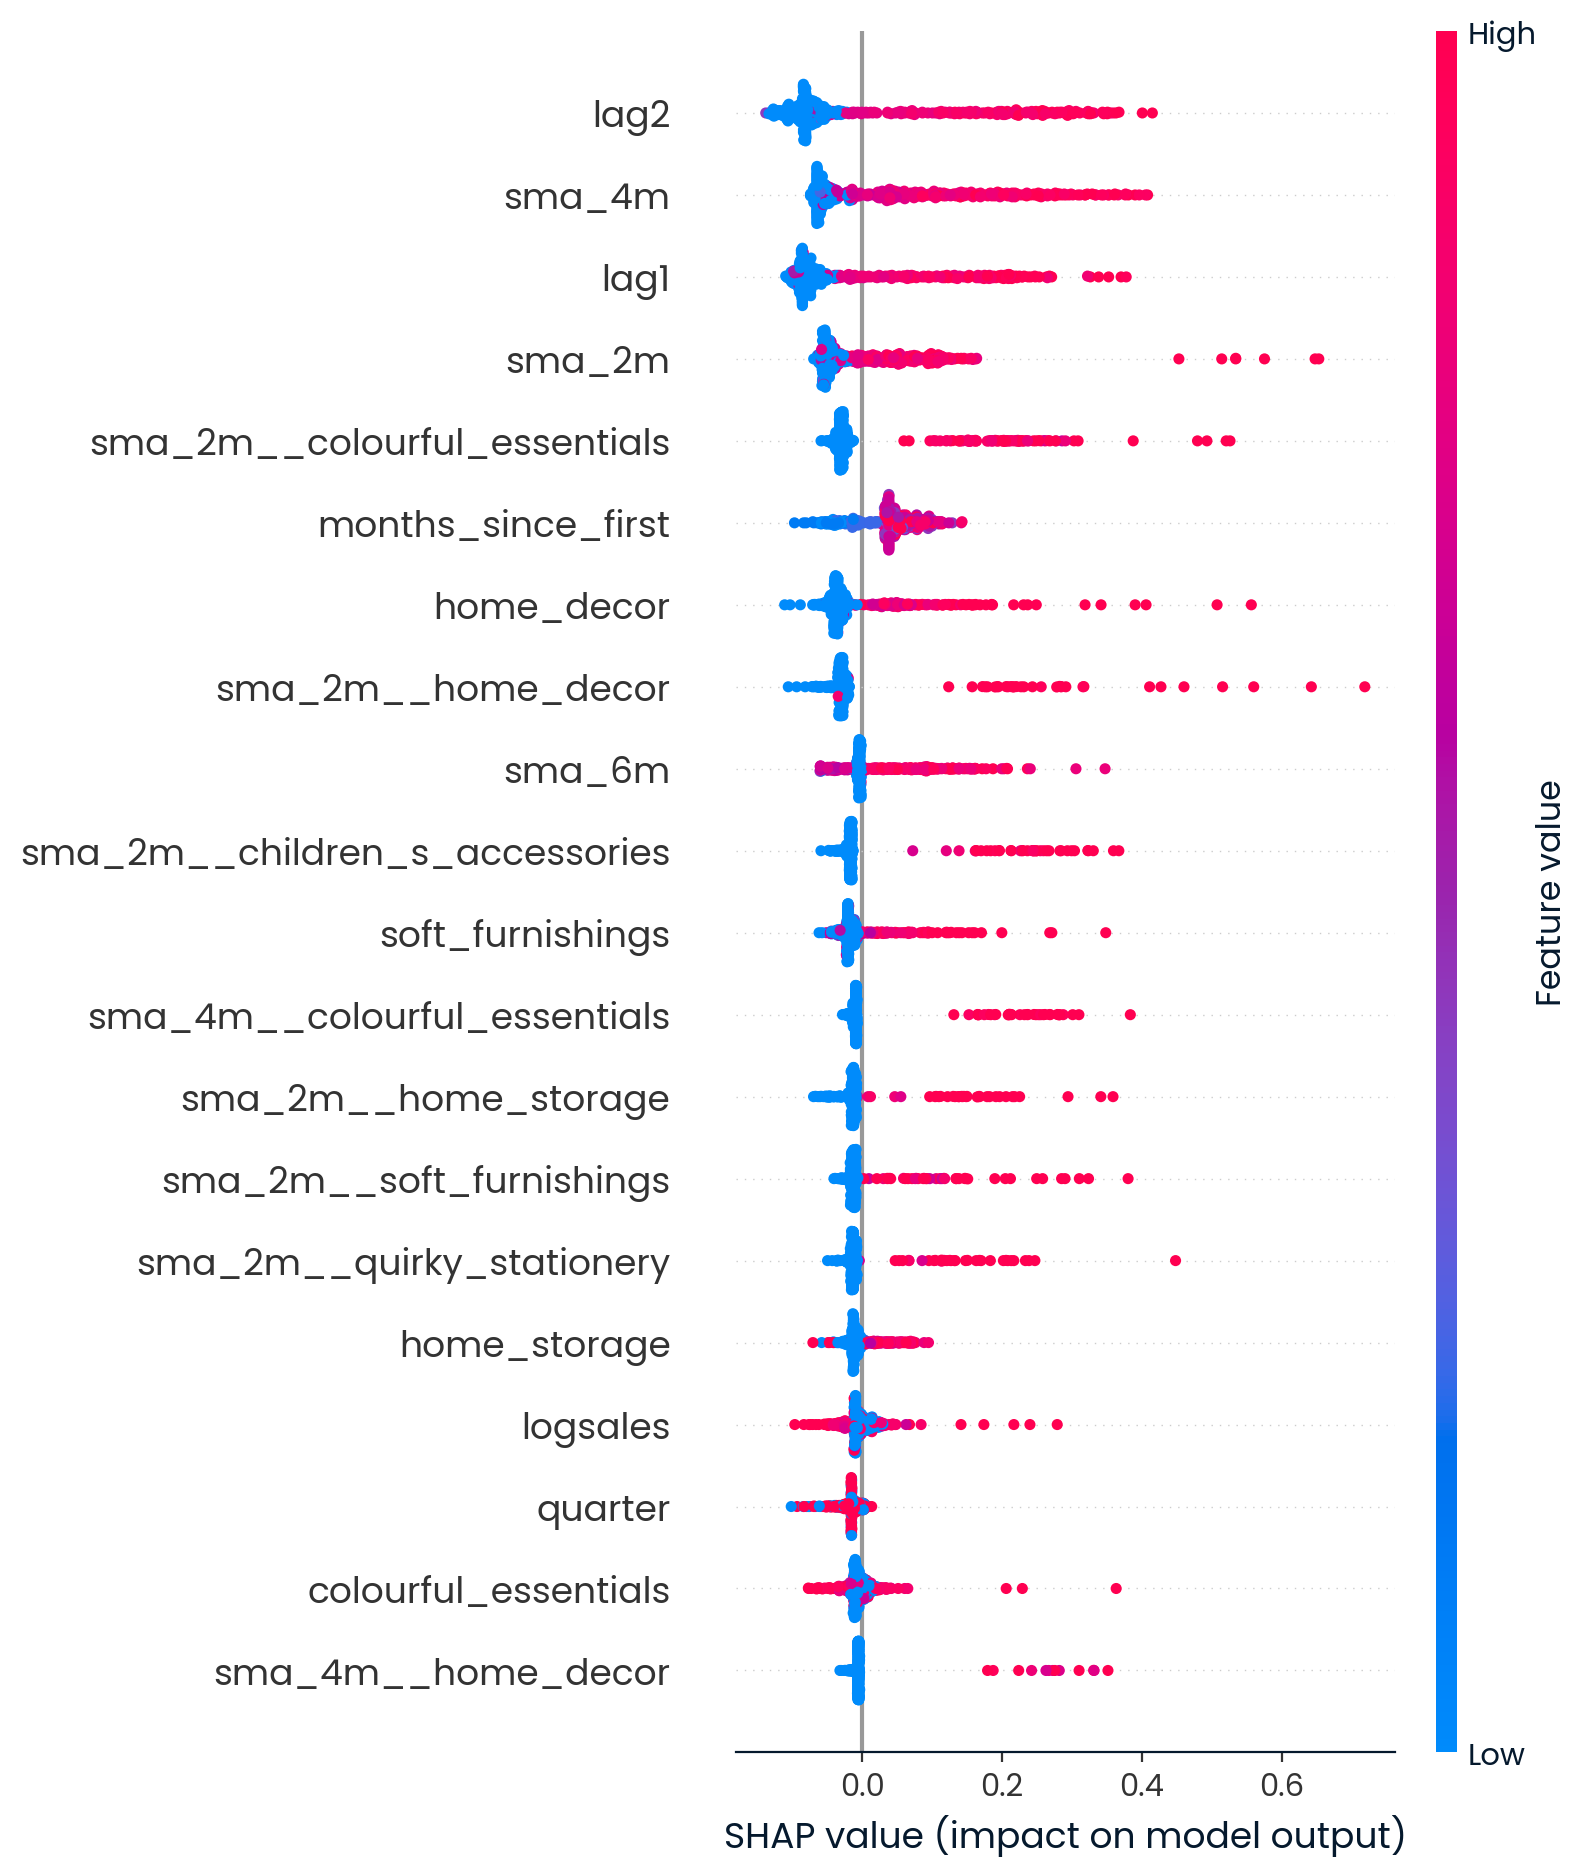

In [2]:
# -------------------------
# 1. Load Libraries
# -------------------------
# These are the tools we need to process data, run models, and explain predictions.
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import shap
import sys

# Ensure you're running this on Python 3.10 — required for some library compatibility.
assert (
    sys.version_info.major == 3 and sys.version_info.minor == 10
), "Please ensure you're using Python 3.10 for compatibility"

# -------------------------
# 2. Load Data & Models
# -------------------------
# We're using a subset of customer transaction data for faster SHAP explanation.
# X_train/X_test: customer behavior data (e.g., past purchases)
# y_train/y_test: actual future home_decor sales (used only for training and validation)
X_train = pd.read_csv("data/X_train.csv").sample(500, random_state=42)
X_test = pd.read_csv("data/X_test.csv").sample(500, random_state=42)
y_train = pd.read_csv("data/y_train.csv")["nextmonth__home_decor"].sample(500, random_state=42)
y_test = pd.read_csv("data/y_test.csv")["nextmonth__home_decor"].sample(500, random_state=42)

# Load our two machine learning models: a Random Forest and a K-Nearest Neighbors model
model = joblib.load("data/model.pkl")         # Random Forest Regressor
knn_model = joblib.load("data/knn_model.pkl") # K-Nearest Neighbors Regressor

# -------------------------
# 2A. Model Training Reference 
# -------------------------
# This block shows how the models were trained. No need to run this unless you’re retraining.

# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(...)
# model.fit(X_train, y_train)

# from sklearn.neighbors import KNeighborsRegressor
# knn_model = KNeighborsRegressor(...)
# knn_model.fit(X_train, y_train)

# -------------------------
# 2B. Explainability Technique
# -------------------------
# We’re using SHAP, a tool from game theory that tells us which features (like past purchases)
# had the biggest influence on the model’s predictions. This helps stakeholders *understand* why the model made a prediction.
xai = "shap"
import shap

# -------------------------
# 3. SHAP for Random Forest
# -------------------------
# Use SHAP’s TreeExplainer since Random Forest is a tree-based model.
# This calculates how much each feature (e.g. past sales, category purchases) affected predicted demand.
explainer_rf = shap.TreeExplainer(model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Average the importance scores to rank the top features
importances_rf = np.abs(shap_values_rf).mean(axis=0)
feat_imp_rf = pd.DataFrame({
    "feature": X_test.columns,
    "importance": importances_rf
}).sort_values(by="importance", ascending=False)

# Show the five most important features
top_feats = feat_imp_rf.head(5)

# -------------------------
# 4. SHAP for KNN Model
# -------------------------
# KNN isn’t tree-based, so we use SHAP’s KernelExplainer (model-agnostic).
# It approximates which features influenced the model for a small sample.
X_test_sample = X_test.sample(50, random_state=42)
background = shap.kmeans(X_test, 5)  # A smart summary sample to speed things up

knn_explainer = shap.KernelExplainer(knn_model.predict, background, seed=42)
X_test_sample = X_test_sample.iloc[:10]  # Use 10 rows to keep processing fast
knn_shap_values = knn_explainer.shap_values(X_test_sample)

# Rank top 5 features influencing the KNN model
importances_knn = np.abs(knn_shap_values).mean(axis=0)
feat_imp_knn = pd.DataFrame({
    "feature": X_test_sample.columns,
    "importance": importances_knn
}).sort_values(by="importance", ascending=False)

top_feats_knn = feat_imp_knn.head(5)

# -------------------------
# 5. Consistency Between Models
# -------------------------
# Let's compare the top 5 features from both models and see if they agree.
# We use cosine similarity — a measure of how similar the two importance rankings are.
# A score near 1.0 = strong agreement.
merged = pd.merge(top_feats, top_feats_knn, on="feature", suffixes=("_rf", "_knn"))

consistency = round(
    cosine_similarity(
        [merged["importance_rf"].values],
        [merged["importance_knn"].values]
    )[0][0], 2
)

reliable = "yes" if consistency >= 0.80 else "no"

# -------------------------
# 6. Final Output (for Execs)
# -------------------------
# This block prints the results — helpful for presentations or reports.
print("\nXAI Method Used:", xai.upper())
print("Top 5 Features from Random Forest:\n", top_feats)
print("Top 5 Features from KNN:\n", top_feats_knn)
print("Feature Importance Consistency Score:", consistency)
print("Are Interpretations Reliable?", reliable)

# -------------------------
# 7. Business Interpretation
# -------------------------
# Key takeaways for marketing, inventory, and product teams:
#
# - 'lag1', 'lag2': If a customer bought home decor 1–2 months ago, they’re likely to buy again.
# - 'sma_4m': A rolling average of past 4-month purchases — great for tracking patterns.
# - 'colourful_essentials': Buying related categories (e.g., colorful decor) predicts future purchases.
#
# MARKETING: Target customers with these past behaviors using personalized offers.
# INVENTORY: Prepare stock based on expected demand from these signals.
# STRATEGY: Create bundle offers that include top co-purchased categories.

# -------------------------
# 8. SHAP Summary Plot (Optional Visual)
# -------------------------
# This visualization shows which features most influenced predictions across all test samples.
# Positive values = feature pushed the prediction up (more demand)
# Negative values = pushed it down (less demand)
shap.summary_plot(shap_values_rf, X_test, show=True)


### Interpretation of the SHAP Summary Plot (for Non-Tech + Business Teams):
This SHAP plot answers:
“What features most influence the model’s prediction of next month’s home décor purchase volume?”

Key Visual Takeaways:
Top Drivers of Demand

The top 5 features consistently driving predictions are:

 - lag2 and lag1: Home décor purchases made 1–2 months ago

 - sma_4m and sma_2m: Short-term spending trends

 - sma_2m__colourful_essentials: Recent purchases in a related category (cross-sell signal)

These customers are repeat buyers or recently active — prime marketing targets.

Color Tells a Story

- Red = high feature value (e.g. high past spending)

- Blue = low feature value (e.g. no past purchases)

You can clearly see that high recent activity (red) in these top features pushes predictions up, meaning more demand.

Strong Positive Push
- Features like lag2, sma_4m, and sma_2m__colourful_essentials consistently push predictions higher when values are high (shown as red points far to the right).

These are reliable buying signals.

Secondary Drivers
Other contributing categories:

- soft_furnishings, home_storage, children_s_accessories, quirky_stationery

Suggests opportunities for category bundles or personalized recommendations.

Negative or Neutral Influence
- Features like quarter and logsales (log-transformed overall sales) cluster around 0, showing minimal predictive value.

 These may be dropped in future model optimization.


## Next Steps
- Expand dataset size for deeper SHAP interpretation.
- Explore time-series specific models (e.g., XGBoost with lag features).
- Integrate this model into inventory/CRM dashboards.